In [7]:
import re
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableMap

# ✅ 공통 LLM
llm = ChatOpenAI(temperature=0)

# ✅ 1. 분류 프롬프트 + 체인
classification_prompt = PromptTemplate.from_template("""
다음 질문을 읽고, 알맞은 유형을 골라주세요.

질문: "{question}"

다음 중 하나로 정확히 대답해 주세요:
- usage (앱 사용법/기능/방법/적금/통장 등)
- news (뉴스/기사/인터뷰 등)
- video (유튜브/영상/뮤직비디오 등)
- person (인물/가수/프로필 등)
- chat (일상대화/잡담)

정답:
""")

classification_chain = RunnableMap({
    "question": lambda x: x["question"]
}) | classification_prompt | llm

# ✅ 2. 쿼리 압축 프롬프트 + 체인
query_compression_prompt = PromptTemplate.from_template("""
다음 질문에서 핵심적인 검색어만 추출해줘. 쓸데없는 표현은 빼고 간단하게 정리해.

질문: "{question}"
검색용 압축 쿼리:
""")

query_compression_chain = RunnableMap({
    "question": lambda x: x["question"]
}) | query_compression_prompt | llm

# ✅ 3. 키워드 기반 룰 분류 함수
def classify_query_rule_based(user_input: str) -> str:
    text = user_input.lower()

    video_keywords = [
    "영상", "유튜브", "동영상", "비디오", "보다", "보여줘", "보여", "클립", "녹화", "재생", "유튭",
    "뮤직비디오", "직캠", "라이브", "풀영상", "티저", "하이라이트",
    "콘서트", "무대", "쇼케이스", "방송분", "팬캠", "유튜브영상", "연출"
    ]


    news_keywords = [
    "뉴스", "기사", "소식", "보도", "속보", "헤드라인", "신문", "이슈", "인터뷰", "발표", "근황",
    "보여줘", "요즘", "근래", "화제", "논란", "리포트", "브리핑", "언급", "언론", "인터뷰내용",
    "보도자료", "보도된", "언론보도"
    ]


    usage_keywords = [
    "앱", "사용법", "기능", "가입", "탈퇴", "설정", "알림", "로그인", "변경", "조회", "등록", "삭제",
    "적금", "예금", "금융", "이자", "은행", "통장", "수익", "상품", "펀드", "방법"
    ]

    person_keywords = [
    "누구야", "누구", "프로필", "정보", "출연", "인물", "소개", "스케줄", "일정",
    "생일", "출생", "나이", "몇살", "이력", "경력", "학력", "활동", "배우", "가수", "알아",
    "키", "몸무게", "취미", "특기", "출신", "데뷔", "경력사항", "이름", "인스타", "sns",
    "관련 인물", "팬카페", "소속사", "가족", "형제", "소속", "직업"
    ]
    
    clean_text = re.sub(r"[^가-힣a-zA-Z0-9\s]", "", text)

    if any(word in clean_text for word in usage_keywords):
        return "usage"
    if any(word in clean_text for word in news_keywords):
        return "news"
    if any(word in clean_text for word in video_keywords):
        return "video"
    if any(word in clean_text for word in person_keywords):
        return "person"
    return "chat"

# nickname_map = {
#     "영웅이": "임영웅",
#     "영웅" : "임영웅",
#     "찬원" : "이찬원",
#     "찬또": "이찬원",
#     "지민이": "박지민",
#     "국이": "정국",
#     # 필요 시 계속 추가
# }

# def replace_nickname(query: str) -> str:
#     for nickname, real_name in nickname_map.items():
#         if nickname in query:
#             query = query.replace(nickname, real_name)
#     return query

# ✅ 4. 분류 + 압축 쿼리 강제 통합 함수
async def classify_query(user_input: str) -> dict:
    rule_result = classify_query_rule_based(user_input)

    if rule_result != "chat":
        # ✅ 압축 쿼리도 함께 생성

        if rule_result == "usage":
            return {
                "type": rule_result,
                "query": user_input
            }
        compressed = await query_compression_chain.ainvoke({"question": user_input})
        compressed = compressed.content.strip()
        # compressed = replace_nickname(compressed)
        return {
            "type": rule_result,
            "query": compressed
        }

    # 룰 분류 실패 → LLM 분류
    llm_result = await classification_chain.ainvoke({"question": user_input})
    llm_type = llm_result.content.strip().lower().split()[0]

    if llm_type not in {"usage", "news", "video", "person", "chat"}:
        llm_type = "chat"

    if llm_type == "chat":
        return {"type": "chat", "input": user_input}

    # ✅ chat 외 분류일 경우 → 압축 쿼리 포함
    compressed = await query_compression_chain.ainvoke({"question": user_input})
    compressed = compressed.content.strip()
    # compressed = replace_nickname(compressed)

    if llm_type == "usage":
        return {
            "type": rule_result,
            "query": user_input
        }

    return {
        "type": llm_type,
        "query": compressed
    }


In [9]:
evaluation_dataset = [
    # ✅ news (20개)
    {"user_input": "아이유 최근 뉴스 알려줘", "ground_truth": "news"},
    {"user_input": "정국 관련된 기사 뭐 있어?", "ground_truth": "news"},
    {"user_input": "방탄소년단 인터뷰 내용 요약해줘", "ground_truth": "news"},
    {"user_input": "요즘 연예계 이슈 알려줘", "ground_truth": "news"},
    {"user_input": "장원영 관련 보도자료 있어?", "ground_truth": "news"},
    {"user_input": "지민이 논란 있었다던데 사실이야?", "ground_truth": "news"},
    {"user_input": "이찬원 최근 근황 기사 있니?", "ground_truth": "news"},
    {"user_input": "연예 뉴스 헤드라인 보여줘", "ground_truth": "news"},
    {"user_input": "기자들이 쓴 임영웅 기사 뭐 있어?", "ground_truth": "news"},
    {"user_input": "아이브 관련 최근 발표된 뉴스는?", "ground_truth": "news"},
    {"user_input": "오늘 연예 기사 뭐가 화제야?", "ground_truth": "news"},
    {"user_input": "엔믹스 관련 속보 나왔어?", "ground_truth": "news"},
    {"user_input": "뉴스 속보 중 연예계 기사 뭐 있어?", "ground_truth": "news"},
    {"user_input": "수지랑 관련된 언론 보도 알려줘", "ground_truth": "news"},
    {"user_input": "아이유가 무슨 이슈 있었어?", "ground_truth": "news"},
    {"user_input": "방송국에서 정국 인터뷰 했대", "ground_truth": "news"},
    {"user_input": "SNS에 올라온 연예계 소식 정리해줘", "ground_truth": "news"},
    {"user_input": "최신 연예 인터뷰 기사 요약해줘", "ground_truth": "news"},
    {"user_input": "연예 뉴스 기사들 종합해줘", "ground_truth": "news"},
    {"user_input": "임영웅 뉴스 다시보기 링크 있어?", "ground_truth": "news"},

    # ✅ video (20개)
    {"user_input": "아이유 영상 보여줘", "ground_truth": "video"},
    {"user_input": "정국이 최근에 찍은 유튜브 영상 있어?", "ground_truth": "video"},
    {"user_input": "방탄 라이브 영상 요약해줘", "ground_truth": "video"},
    {"user_input": "유튜브에 올라온 이찬원 영상 뭐 있어?", "ground_truth": "video"},
    {"user_input": "뮤직비디오 보고 싶어", "ground_truth": "video"},
    {"user_input": "콘서트 하이라이트 영상 줘", "ground_truth": "video"},
    {"user_input": "정국 직캠 영상 검색해줘", "ground_truth": "video"},
    {"user_input": "아이브 무대 영상 볼 수 있어?", "ground_truth": "video"},
    {"user_input": "이찬원 방송 클립 어디서 봐?", "ground_truth": "video"},
    {"user_input": "브이라이브 다시보기 링크 줘", "ground_truth": "video"},
    {"user_input": "쇼케이스 영상 정리해줘", "ground_truth": "video"},
    {"user_input": "티저 영상이 궁금해", "ground_truth": "video"},
    {"user_input": "아이유가 부른 영상 찾아줘", "ground_truth": "video"},
    {"user_input": "정국 팬캠 영상 뭐 있어?", "ground_truth": "video"},
    {"user_input": "무대 리허설 영상 있을까?", "ground_truth": "video"},
    {"user_input": "이찬원 라이브 영상 보여줘", "ground_truth": "video"},
    {"user_input": "임영웅 유튜브 채널 뭐야?", "ground_truth": "video"},
    {"user_input": "영상 클립 요약해줘", "ground_truth": "video"},
    {"user_input": "최근 올라온 직캠 뭐 있어?", "ground_truth": "video"},
    {"user_input": "노래 부르는 영상 찾고 싶어", "ground_truth": "video"},

    # ✅ usage (20개)
    {"user_input": "앱 기능 알려줘", "ground_truth": "usage"},
    {"user_input": "이 앱에서 알림 설정 어떻게 해?", "ground_truth": "usage"},
    {"user_input": "비밀번호 바꾸는 방법 좀", "ground_truth": "usage"},
    {"user_input": "로그인 오류 어떻게 해결해?", "ground_truth": "usage"},
    {"user_input": "이 앱에 적금 상품 뭐 있어?", "ground_truth": "usage"},
    {"user_input": "통장 만들려면 어떻게 해?", "ground_truth": "usage"},
    {"user_input": "가입은 어디서 해?", "ground_truth": "usage"},
    {"user_input": "앱 탈퇴하려면 어떻게 해야 해?", "ground_truth": "usage"},
    {"user_input": "프로필 사진 바꾸는 법 알려줘", "ground_truth": "usage"},
    {"user_input": "예금 금리는 몇 퍼야?", "ground_truth": "usage"},
    {"user_input": "상품 비교 기능 있어?", "ground_truth": "usage"},
    {"user_input": "계좌 삭제하려면 어떻게 해?", "ground_truth": "usage"},
    {"user_input": "알림 끄는 방법 좀", "ground_truth": "usage"},
    {"user_input": "수익 확인 어디서 해?", "ground_truth": "usage"},
    {"user_input": "적금 자동이체 설정 어떻게 해?", "ground_truth": "usage"},
    {"user_input": "앱에서 통장 개설할 수 있어?", "ground_truth": "usage"},
    {"user_input": "이자 얼마나 받아?", "ground_truth": "usage"},
    {"user_input": "펀드 가입은 어디서 하지?", "ground_truth": "usage"},
    {"user_input": "은행 연결 어떻게 해?", "ground_truth": "usage"},
    {"user_input": "계좌 조회 어떻게 하는 거야?", "ground_truth": "usage"},

    # ✅ person (20개)
    {"user_input": "정국 프로필 알려줘", "ground_truth": "person"},
    {"user_input": "아이유는 누구야?", "ground_truth": "person"},
    {"user_input": "이찬원 나이 몇이야?", "ground_truth": "person"},
    {"user_input": "장원영 생일이 언제야?", "ground_truth": "person"},
    {"user_input": "지민이 키 몇이야?", "ground_truth": "person"},
    {"user_input": "임영웅 출생지는 어디야?", "ground_truth": "person"},
    {"user_input": "박보검 어떤 사람이야?", "ground_truth": "person"},
    {"user_input": "정국 취미가 뭐야?", "ground_truth": "person"},
    {"user_input": "아이유 소속사는 어디?", "ground_truth": "person"},
    {"user_input": "이찬원 가족관계 알려줘", "ground_truth": "person"},
    {"user_input": "수지 경력 좀 보여줘", "ground_truth": "person"},
    {"user_input": "지민 데뷔 언제 했어?", "ground_truth": "person"},
    {"user_input": "장원영 학교 어디 나왔어?", "ground_truth": "person"},
    {"user_input": "임영웅 취미는 뭐야?", "ground_truth": "person"},
    {"user_input": "정국 특기는 뭘까?", "ground_truth": "person"},
    {"user_input": "이름이 뭐였더라 그 가수?", "ground_truth": "person"},
    {"user_input": "프로필 사진 있어?", "ground_truth": "person"},
    {"user_input": "인스타그램 아이디 알려줘", "ground_truth": "person"},
    {"user_input": "이찬원 학력은?", "ground_truth": "person"},
    {"user_input": "배우 박서준 정보 좀 줘", "ground_truth": "person"},

    # ✅ chat (20개)
    {"user_input": "오늘 날씨 너무 춥다", "ground_truth": "chat"},
    {"user_input": "기분이 이상해", "ground_truth": "chat"},
    {"user_input": "졸리다 진짜", "ground_truth": "chat"},
    {"user_input": "심심해 뭐하지", "ground_truth": "chat"},
    {"user_input": "밥 뭐 먹을까", "ground_truth": "chat"},
    {"user_input": "졸려 죽겠네", "ground_truth": "chat"},
    {"user_input": "시간 참 빠르다", "ground_truth": "chat"},
    {"user_input": "어제 잠을 못 잤어", "ground_truth": "chat"},
    {"user_input": "오늘 하루 어땠어?", "ground_truth": "chat"},
    {"user_input": "기분전환 하고 싶어", "ground_truth": "chat"},
    {"user_input": "아 피곤해", "ground_truth": "chat"},
    {"user_input": "따뜻한 노래 추천해줘", "ground_truth": "chat"},
    {"user_input": "기억 안 나는데 말 좀 걸어줘", "ground_truth": "chat"},
    {"user_input": "요즘 너무 바빠", "ground_truth": "chat"},
    {"user_input": "그냥 이야기나 하자", "ground_truth": "chat"},
    {"user_input": "외로워...", "ground_truth": "chat"},
    {"user_input": "말동무가 필요해", "ground_truth": "chat"},
    {"user_input": "그거 아냐? 요즘 진짜 바쁘더라", "ground_truth": "chat"},
    {"user_input": "대화하고 싶어", "ground_truth": "chat"},
    {"user_input": "그냥 잡담 좀 하자", "ground_truth": "chat"},
]


In [10]:
import asyncio
from sklearn.metrics import classification_report
from tqdm import tqdm  # 진행률 바

# 📊 평가 실행 함수
async def evaluate_router(dataset):
    y_true = []
    y_pred = []

    for sample in tqdm(dataset):
        user_input = sample["user_input"]
        true_label = sample["ground_truth"]

        try:
            result = await classify_query(user_input)
            predicted_label = result["type"]
        except Exception as e:
            print(f"❌ 에러 발생: {e}")
            predicted_label = "chat"  # fallback

        y_true.append(true_label)
        y_pred.append(predicted_label)

    print("📊 Routing Classification Report:")
    print(classification_report(y_true, y_pred, labels=["usage", "news", "video", "person", "chat"]))

# 실행
asyncio.run(evaluate_router(evaluation_dataset))

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]

📊 Routing Classification Report:
              precision    recall  f1-score   support

       usage       1.00      0.95      0.97        20
        news       0.80      1.00      0.89        20
       video       0.95      0.90      0.92        20
      person       0.95      0.95      0.95        20
        chat       1.00      0.85      0.92        20

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100



In [11]:
import asyncio
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# ✅ 평가할 데이터셋 (100개짜리 사용)
# from your_dataset_file import evaluation_dataset

# ✅ 체인 순서 정의 (Confusion Matrix 및 시각화용)
label_order = ["usage", "news", "video", "person", "chat"]

# ✅ 평가 함수
async def evaluate_router(dataset):
    y_true = []
    y_pred = []

    for sample in tqdm(dataset):
        user_input = sample["user_input"]
        true_label = sample["ground_truth"]

        try:
            result = await classify_query(user_input)
            predicted_label = result["type"]
        except Exception as e:
            print(f"❌ 에러 발생: {e}")
            predicted_label = "chat"  # fallback

        y_true.append(true_label)
        y_pred.append(predicted_label)

    # ✅ 텍스트 리포트 출력
    print("\n📊 Routing Classification Report:\n")
    print(classification_report(y_true, y_pred, labels=label_order))

    # ✅ Confusion Matrix 시각화
    cm = confusion_matrix(y_true, y_pred, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("📌 Routing Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2532\1432321572.py:46: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\SSAFY\Desktop\project_2\S12P21A702\finafanAI\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



📊 Routing Classification Report:

              precision    recall  f1-score   support

       usage       1.00      0.95      0.97        20
        news       0.80      1.00      0.89        20
       video       0.95      0.90      0.92        20
      person       0.95      0.95      0.95        20
        chat       1.00      0.85      0.92        20

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100



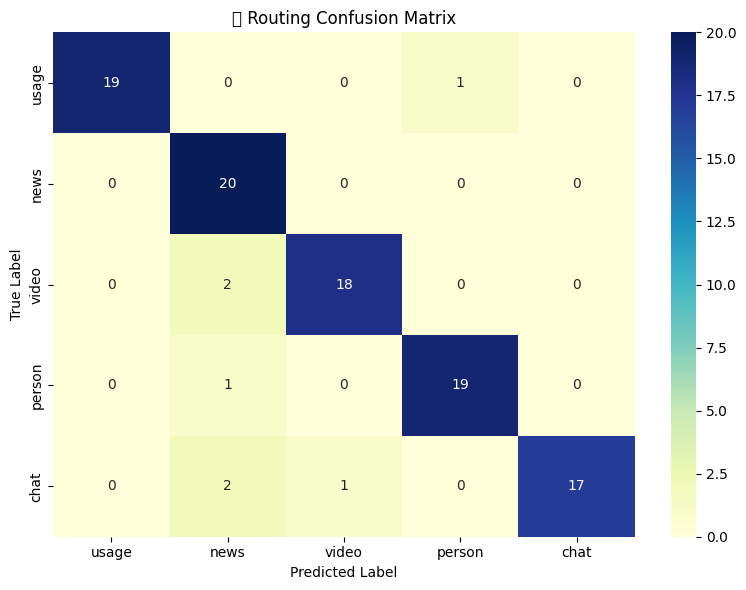

In [12]:
asyncio.run(evaluate_router(evaluation_dataset))

In [13]:
import asyncio
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# 📌 라벨 순서 정의
label_order = ["usage", "news", "video", "person", "chat"]

# ✅ 평가 함수
async def evaluate_router(dataset):
    y_true = []
    y_pred = []

    for sample in tqdm(dataset):
        user_input = sample["user_input"]
        true_label = sample["ground_truth"]

        try:
            result = await classify_query(user_input)
            predicted_label = result["type"]
        except Exception as e:
            print(f"❌ 에러 발생: {e}")
            predicted_label = "chat"  # fallback

        y_true.append(true_label)
        y_pred.append(predicted_label)

    # 📊 텍스트 리포트 출력
    print("\n📊 Classification Report:\n")
    report = classification_report(y_true, y_pred, labels=label_order, output_dict=True)
    print(classification_report(y_true, y_pred, labels=label_order))

    # ✅ Confusion Matrix 시각화
    cm = confusion_matrix(y_true, y_pred, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="YlGnBu")
    plt.title("📌 Routing Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # ✅ Precision, Recall, F1-score 그래프 시각화
    scores_df = pd.DataFrame(report).transpose().loc[label_order, ["precision", "recall", "f1-score"]]

    scores_df.plot(kind="bar", figsize=(10, 6), ylim=(0, 1.1))
    plt.title("📈 Precision / Recall / F1-score by Class")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2532\3724725233.py:44: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\SSAFY\Desktop\project_2\S12P21A702\finafanAI\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



📊 Classification Report:

              precision    recall  f1-score   support

       usage       1.00      0.95      0.97        20
        news       0.80      1.00      0.89        20
       video       0.95      0.90      0.92        20
      person       0.95      0.95      0.95        20
        chat       1.00      0.85      0.92        20

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100



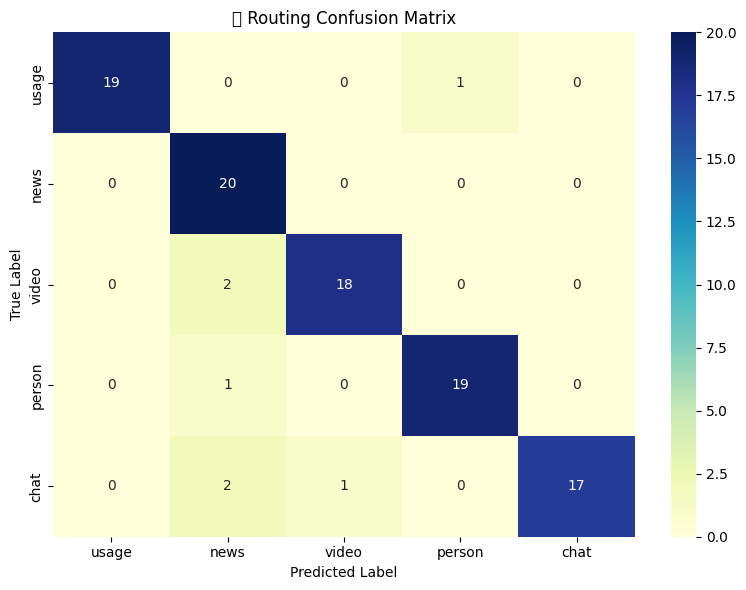

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2532\3724725233.py:56: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\SSAFY\Desktop\project_2\S12P21A702\finafanAI\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


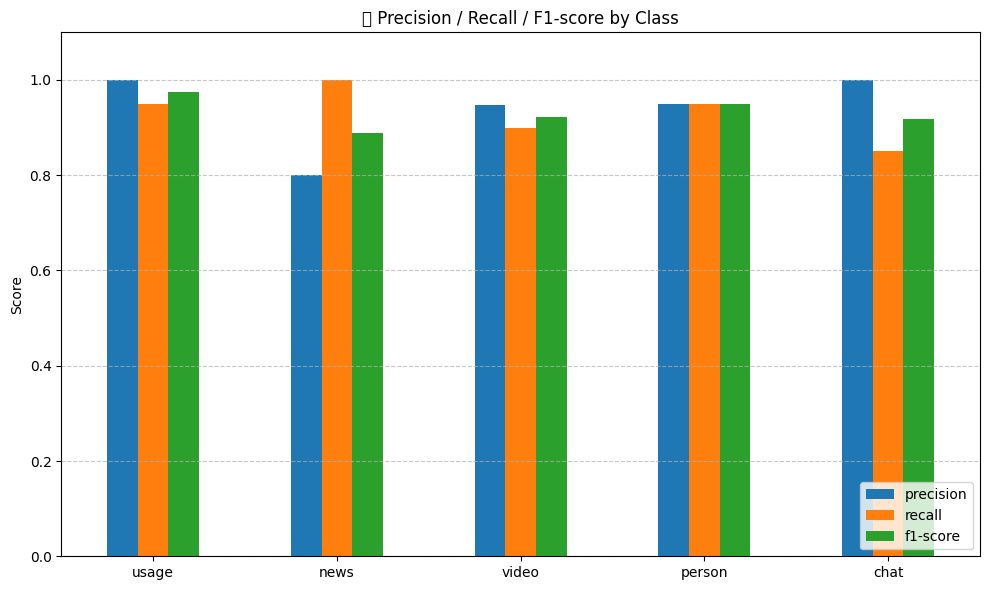

In [14]:
# 실행
asyncio.run(evaluate_router(evaluation_dataset))
